# match Chris's catalogs to CAMELS

In [1]:
import os
import h5py 
import numpy as np

In [2]:
from astropy.table import Table

In [3]:
import corner as DFM
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False

In [4]:
_dir = '/tigress/chhahn/goleta/'
lovell = h5py.File(os.path.join(_dir, 'tng_lovell.hdf5'), 'r')

In [5]:
tng = h5py.File(os.path.join(_dir, 'tng.snap33.subfind.galaxies.LHC.hdf5'), 'r')

In [6]:
photo = [] 
for i_lhc in range(1000): 
    isubs = tng['props'][-1,:][tng['props'][-2,:].astype(int) == i_lhc].astype(int)
    
    im = np.in1d(lovell['%i/SubhaloIndex' % i_lhc][...], isubs)
    assert np.sum(isubs-lovell['%i/SubhaloIndex' % i_lhc][...][im]) == 0
    
    _photo = np.zeros((np.sum(tng['props'][-2,:].astype(int) == i_lhc), 5))
    for i_b, band in enumerate(['u', 'g', 'r', 'i', 'z']): 
        # convert Lnu to abs mag units
        Lnu = lovell['%i/attenuated/SLOAN/SDSS.%s' % (i_lhc, band)][...][im]        
        geo = 4 * np.pi * (10 * 3.08567758128e18) ** 2

        _photo[:,i_b] = -2.5 * np.log10(Lnu / geo) - 48.6
    photo.append(_photo)

In [7]:
photo = np.concatenate(photo, axis=0)

In [10]:
tng['props'][-6:-2].T

array([[-23.42693329, -24.05015182, -24.37333679, -24.61043739],
       [-21.251091  , -21.64406013, -21.87215042, -22.04977226],
       [-19.9505043 , -20.69135094, -21.04071236, -21.28896141],
       ...,
       [-15.97211361, -16.58961487, -16.86730766, -17.0278244 ],
       [-15.34203339, -15.97955227, -16.27163506, -16.43307686],
       [-15.31627655, -15.98023033, -16.28874588, -16.46620369]])

In [11]:
photo[:,1:5]

array([[-22.91294886, -23.47860227, -23.65429341, -23.81331507],
       [-21.01932214, -21.57093406, -21.3778677 , -21.4823316 ],
       [-19.6086894 , -20.11191313, -20.34976113, -20.49825183],
       ...,
       [-15.49387968, -15.8711375 , -16.07878626, -16.21285955],
       [-15.60957446, -15.95460583, -16.15745627, -16.28970939],
       [-15.72402075, -16.01658103, -16.20353453, -16.33101924]])

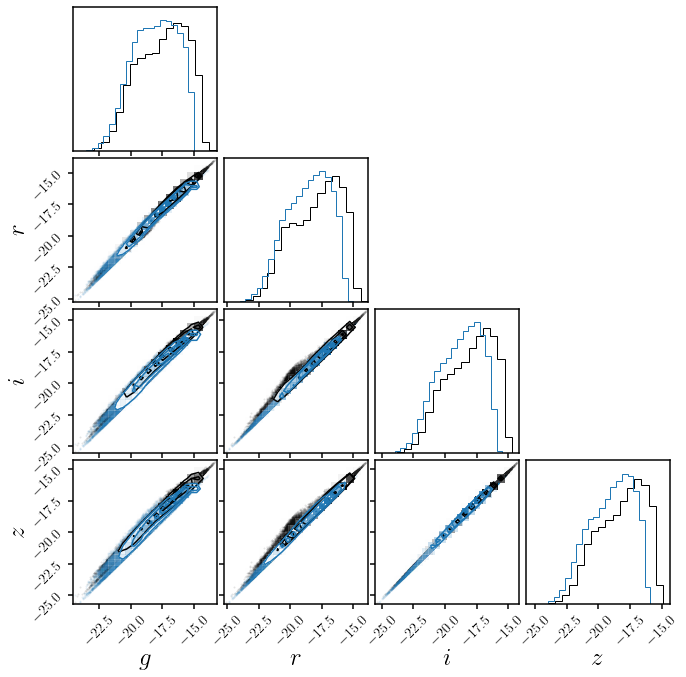

In [19]:
fig = DFM.corner(photo[::10,1:], color='k', hist_kwargs={'density': True})
_ = DFM.corner(tng['props'][-6:-2].T[::10], color='C0', hist_kwargs={'density': True}, 
               range=[(-24, -15) for i in range(4)], labels=[r'$%s$' % b for b in ['g', 'r', 'i', 'z']],
               label_kwargs={'fontsize': 25}, fig=fig)

In [8]:
#np.savetxt(os.path.join(_dir, 'tng_lovell.matched.sdss_ugriz.dat'), photo, header='SDSS u, g, r, i, z abs. mag.')

In [3]:
#photo = np.loadtxt('/tigress/chhahn/goleta/tng_lovell.matched.sdss_ugriz.dat', skiprows=1)

In [12]:
# read NSA catlaog
nsa = Table.read('/tigress/chhahn/goleta/nsa_v0_1_2.fits')

# get k-correction absolute magnitudes --- u, g, r, i, z
absmag_nsa = np.array(nsa['ABSMAG'].data)[:,2:]

cuts = (nsa['Z'] < 0.05) # training data is only at z=0
absmag_nsa = absmag_nsa[cuts]

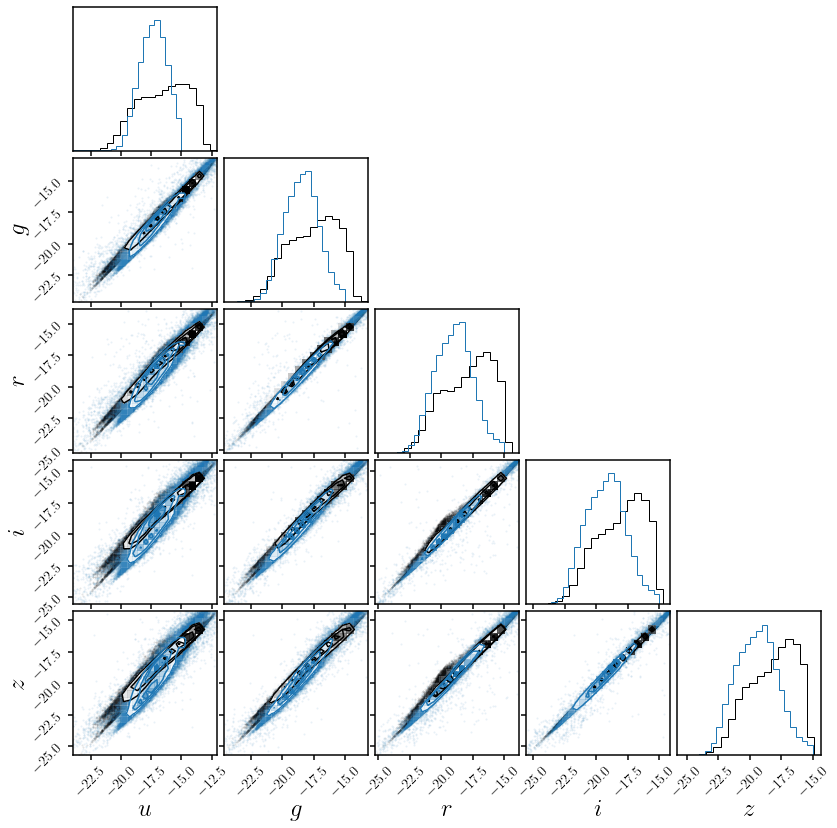

In [21]:
fig = DFM.corner(photo[::10], color='k', hist_kwargs={'density': True})
_ = DFM.corner(absmag_nsa, color='C0', hist_kwargs={'density': True},
               range=[(-24, -15) for i in range(5)], labels=[r'$%s$' % b for b in ['u', 'g', 'r', 'i', 'z']],
               label_kwargs={'fontsize': 25}, fig=fig)

In [25]:
colors_nsa, colors_camels, colors_camels_old, lbls = [], [], [], []
for i in range(5): 
    for j in range(5): 
        if i < j: 
            colors_nsa.append(absmag_nsa[:,i] - absmag_nsa[:,j])
            colors_camels.append(photo[:,i] - photo[:,j])
            if i == 0: colors_camels_old.append(None)
            else: colors_camels_old.append(tng['props'][-6:-2][i-1] - tng['props'][-6:-2][j-1])
            lbls.append(r'$%s - %s$' % (['u', 'g', 'r', 'i', 'z'][i], ['u', 'g', 'r', 'i', 'z'][j]))
colors_nsa = np.array(colors_nsa).T
colors_camels = np.array(colors_camels).T

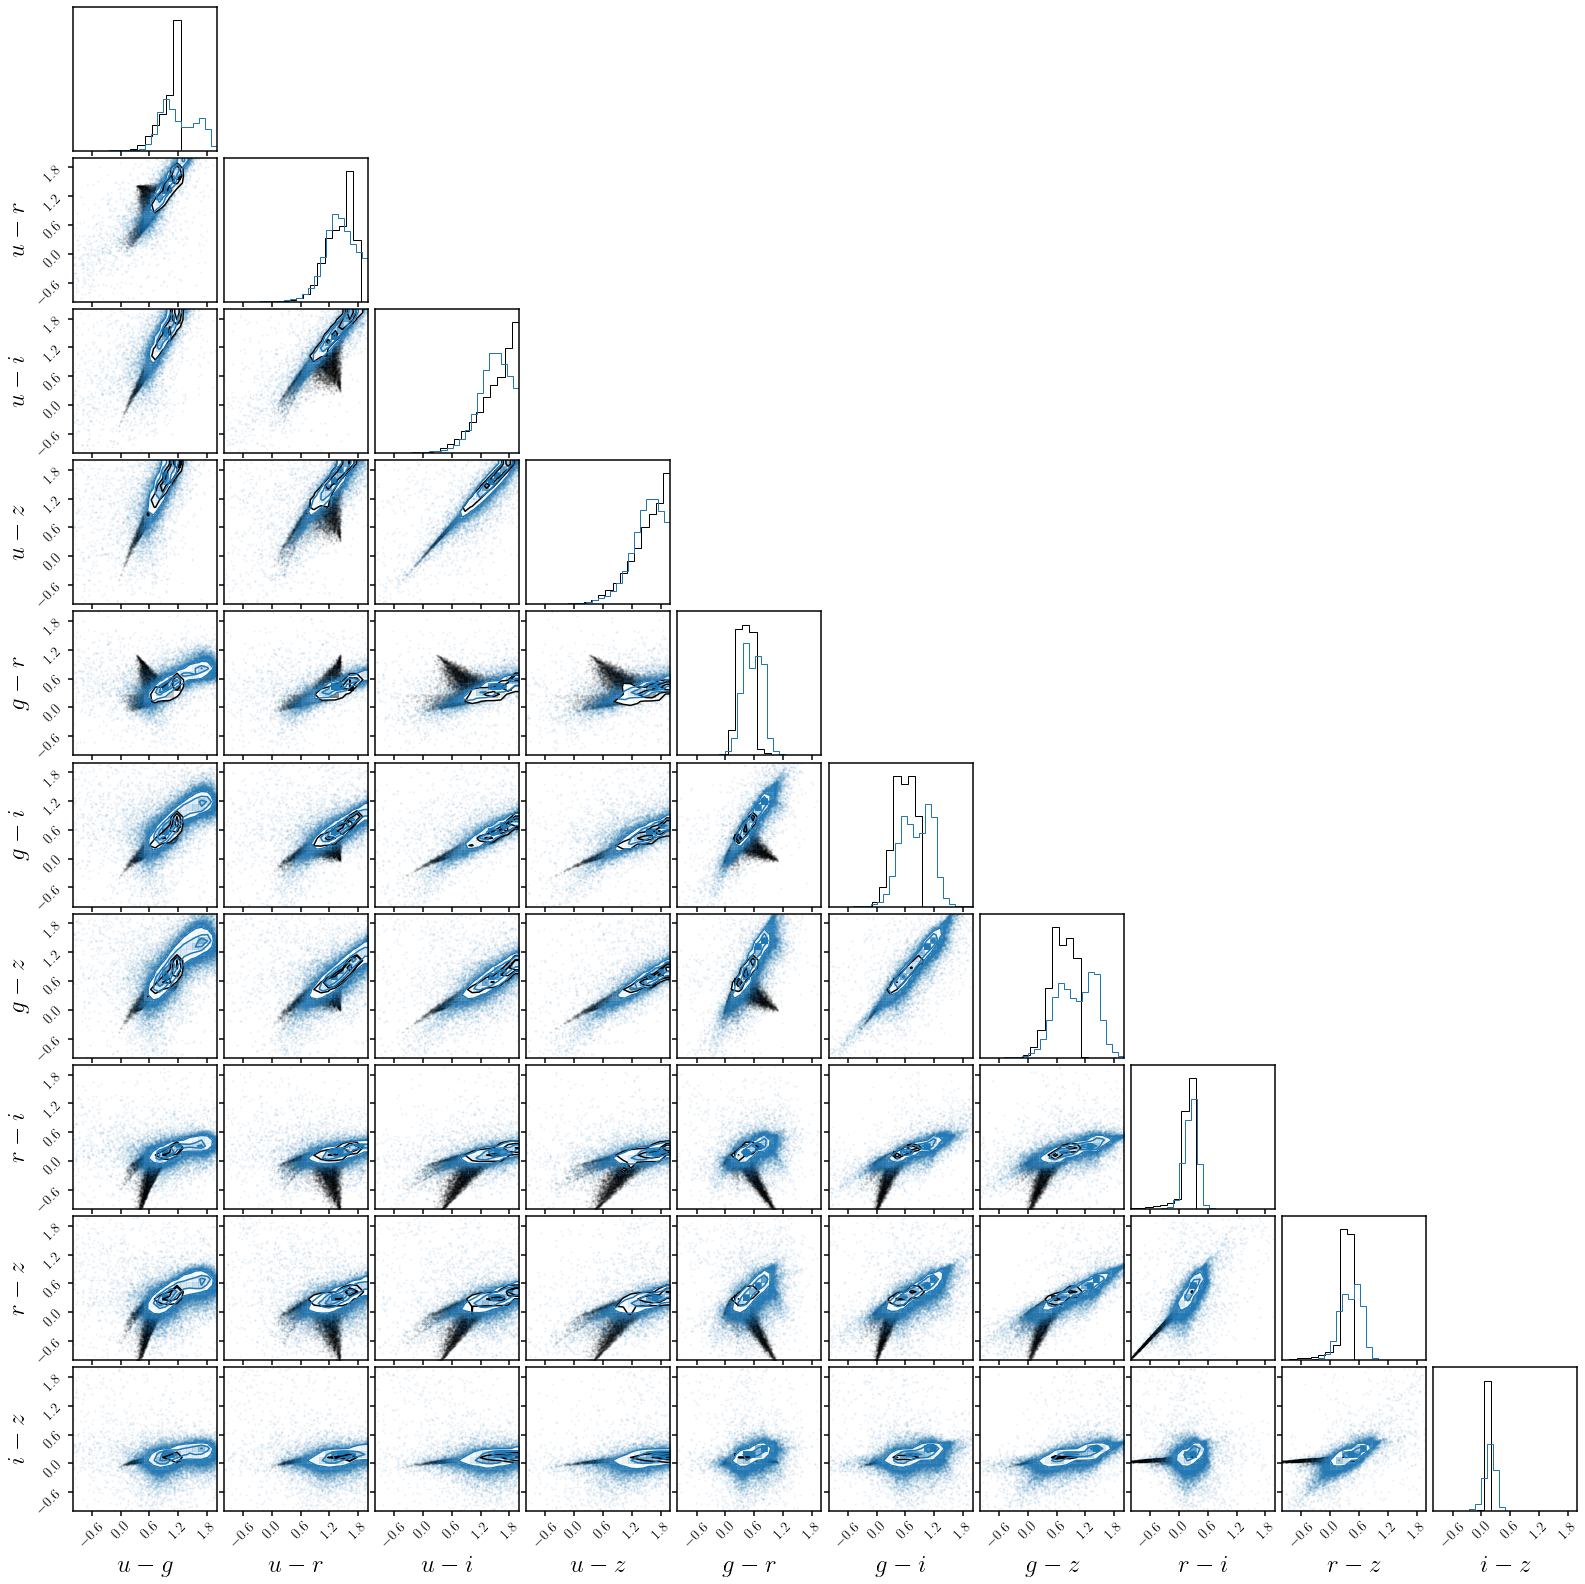

In [23]:
fig = DFM.corner(colors_camels[::10], color='k', 
                hist_kwargs={'density': True}, range=[(-1, 2) for i in range(colors_nsa.shape[1])])
_ = DFM.corner(colors_nsa, color='C0', 
               hist_kwargs={'density': True},
               range=[(-0.5, 2) for i in range(colors_nsa.shape[1])],
               labels=lbls, label_kwargs={'fontsize': 25}, 
               fig=fig)

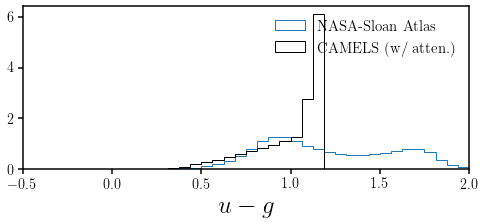

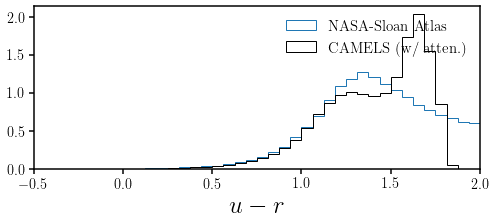

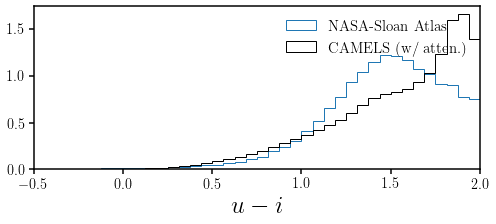

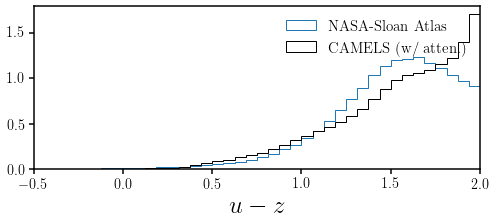

[0.62321854 0.39296913 0.74084663 ... 0.61750126 0.63751888 0.66395378]


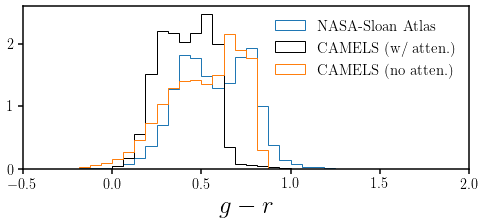

[0.9464035  0.62105942 1.09020805 ... 0.89519405 0.92960167 0.97246933]


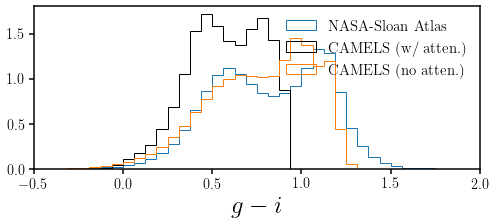

[1.1835041  0.79868126 1.33845711 ... 1.05571079 1.09104347 1.14992714]


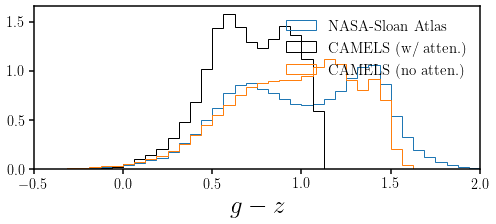

[0.32318497 0.22809029 0.34936142 ... 0.27769279 0.29208279 0.30851555]


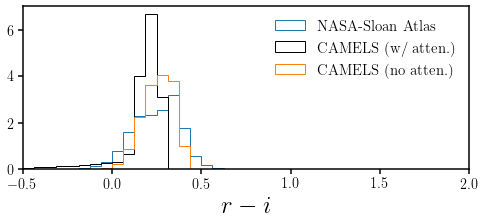

[0.56028557 0.40571213 0.59761047 ... 0.43820953 0.45352459 0.48597336]


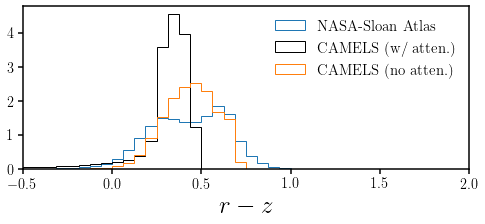

[0.2371006  0.17762184 0.24824905 ... 0.16051674 0.1614418  0.17745781]


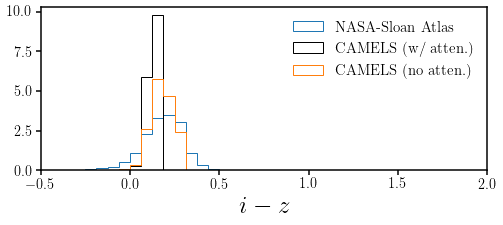

In [28]:
for col1, col2, col3, lbl in zip(colors_nsa.T, colors_camels.T, colors_camels_old, lbls):
    fig = plt.figure(figsize=(8,3))
    sub = fig.add_subplot(111)
    _ = sub.hist(col1, range=(-0.5, 2), bins=40, histtype='step', color='C0', density=True, label='NASA-Sloan Atlas')
    _ = sub.hist(col2, range=(-0.5, 2), bins=40, histtype='step', color='k', density=True, label='CAMELS (w/ atten.)') 
    if col3 is not None: 
        print(col3)
        _ = sub.hist(col3, range=(-0.5, 2), bins=40, histtype='step', color='C1', density=True, label='CAMELS (no atten.)')
    sub.legend(loc='upper right', fontsize=15)
    sub.set_xlabel(lbl, fontsize=25)
    sub.set_xlim(-0.5, 2.)#np.quantile(color, (0.005, 0.99)))
    plt.show()